<a href="https://colab.research.google.com/github/cmannnn/practical_deep_learning_for_coders/blob/main/deep_learning_for_coders_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 8.2MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 1.2MB 34.6MB/s 
     |████████████████████████████████| 204kB 43.5MB/s 
     |████████████████████████████████| 61kB 10.1MB/s 
     |████████████████████████████████| 61kB 10.3MB/s 
Mounted at /content/gdrive


In [ ]:
#hide
from fastbook import *
from fastai.vision.widgets import *

# Chapter 1

## ResNet Cat/dog predictor

In [ ]:
#id first_training
#caption Results from the first training
# CLICK ME
from fastai.vision.all import *
path = untar_data(URLs.PETS)/'images'

def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct = 0.2, seed = 42,
    label_func=is_cat, item_tfms=Resize(224))

learn = cnn_learner(dls, resnet34, metrics = error_rate)
learn.fine_tune(1)

In [ ]:
#hide_output
uploader = widgets.FileUpload()
uploader

In [ ]:
#hide
# For the book, we can't actually click an upload button, so we fake it
uploader = SimpleNamespace(data = ['/content/doggo.jpeg'])
uploader

In [ ]:
img = PILImage.create(uploader.data[0])
is_cat,_,probs = learn.predict(img)
print(f"Is this a cat?: {is_cat}.")
print(f"Probability it's a cat: {probs[1].item():.6f}")

## LSTM movie NLP model

In [ ]:
from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid = 'test')
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult = 0.5, metrics = accuracy)
learn.fine_tune(4, 1e-2)

In [ ]:
learn.predict("I really liked that movie!")

## Socioeconomic indicator

In [ ]:
from fastai.tabular.all import *
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path = path, y_names = "salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation',
                 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

learn = tabular_learner(dls, metrics = accuracy)

In [ ]:
learn.fit_one_cycle(3)

## Movie predictor

In [ ]:
from fastai.collab import *
path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')
learn = collab_learner(dls, y_range = (0.5, 5.5))
learn.fine_tune(10)

In [ ]:
learn.show_results()

# Chapter 2

## Bear classifier

In [ ]:
# getting Azure Bing search key and setting it to key
key = os.environ.get('AZURE_SEARCH_KEY', 'a80b54eb571b45658bbad8530262ff7f')

In [ ]:
# testing search_images_bing method to see if azure key works
search_images_bing

<function fastbook.search_images_bing>

In [ ]:
# using key to search 'grizzly bear' into bing image search
results = search_images_bing(key, 'grizzly bear')

# grabbing the url's of the results
ims = results.attrgot('content_url')

# checking the length of the URL's
print(f'The number of URL\'s downloaded is: {len(ims)}')

The number of URL's downloaded is: 150


In [ ]:
# one random grizzly bear URL
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

# downloading the random grizzly bear URL
dest = 'images'
download_url(ims[0], dest)

In [ ]:
# mounting Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


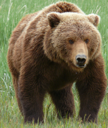

In [ ]:
# opening downloaded random grizzly bear as 128 x 128 rectangle 
im = Image.open(dest)
im.to_thumb(128,128)

In [ ]:
# creating folder string for each type of bear
bear_types = 'grizzly','black','teddy'

# creating a new main folder in our path called 'bears'
path = Path('bears')

In [ ]:
# loop to create new directory with 
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [ ]:
# verifying there are pictures in the bears directory
fns = get_image_files(path)
fns

(#387) [Path('bears/black/00000079.jpg'),Path('bears/black/00000014.jpeg'),Path('bears/black/00000114.jpg'),Path('bears/black/00000058.jpg'),Path('bears/black/00000069.jpeg'),Path('bears/black/00000042.jpg'),Path('bears/black/00000066.jpg'),Path('bears/black/00000133.jpg'),Path('bears/black/00000095.jpg'),Path('bears/black/00000000.jpg')...]

In [ ]:
# checking if any images are corrupted
failed = verify_images(fns)
failed

# removinga any corrupted files
failed.map(Path.unlink)

(#7) [None,None,None,None,None,None,None]

In [ ]:
# creating categorical datablock, identify independent/dependent variables, randomly splitting 20%, 
# using subfolder name as the y value, and resizing the pictures to 128 squares 
bears = DataBlock(
    blocks = (ImageBlock, CategoryBlock), 
    get_items = get_image_files, 
    splitter = RandomSplitter(valid_pct = 0.2, seed = 14),
    get_y = parent_label,
    item_tfms = Resize(128))

In [ ]:
# defining the images source
dls = bears.dataloaders(path)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


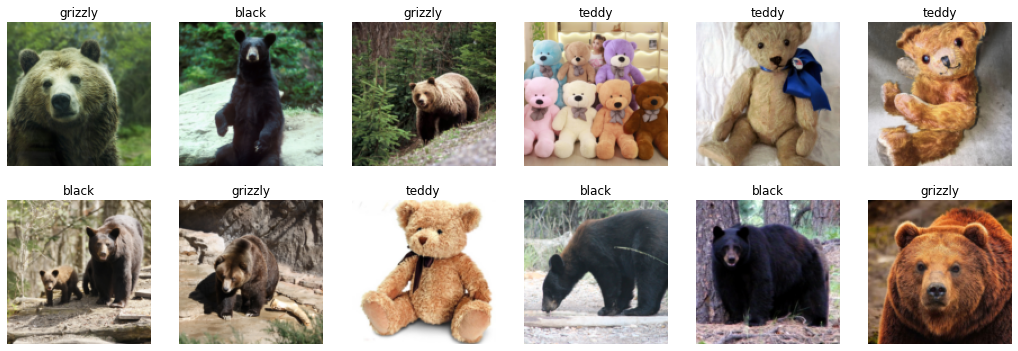

In [ ]:
# showing 6 bear images
dls.valid.show_batch(max_n = 12, nrows = 2)

In [ ]:
# how to resize images? SQUISHING to fit 128 x 128 
bears = bears.new(item_tfms = Resize(128, ResizeMethod.Squish))

# defining the images source
dls = bears.dataloaders(path)

# showing 6 bear images
dls.valid.show_batch(max_n = 12, nrows = 2)

In [ ]:
# how to resize images? PADDING to fit 128 x 128 
bears = bears.new(item_tfms = Resize(128, ResizeMethod.Pad, pad_mode = 'zeros'))

# defining the images source
dls = bears.dataloaders(path)

# showing 6 bear images
dls.valid.show_batch(max_n = 12, nrows = 2)

In [ ]:
# how to resize images? RANDOMLY CROPPING to fit 128 x 128
bears = bears.new(item_tfms = RandomResizedCrop(128, min_scale = 0.3))

# defining the images source
dls = bears.dataloaders(path)

# showing 6 bear images
dls.train.show_batch(max_n = 12, nrows = 2, unique = False)

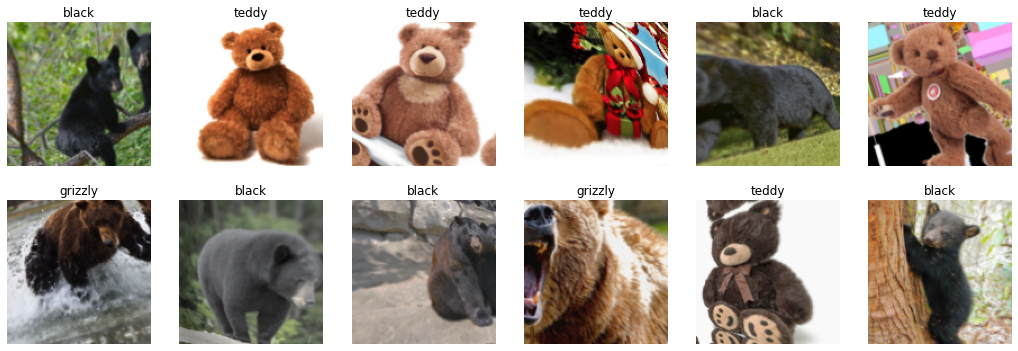

In [ ]:
# how to resize images? AUGUMENTING THEN RESIZING to fit 128 x 128
bears = bears.new(item_tfms = Resize(128), batch_tfms = aug_transforms(mult = 2))

# defining the images source
dls = bears.dataloaders(path)

# showing 6 bear images
dls.train.show_batch(max_n = 12, nrows = 2, unique = False)

In [ ]:
# going with randomly resizing to 224 x 224, cropping with parameter 0.5, and augumenting 
bears = bears.new(
    item_tfms = RandomResizedCrop(224, min_scale = 0.5),
    batch_tfms = aug_transforms())

# defining the images source
dls = bears.dataloaders(path)

In [ ]:
# defining learn with a pretrained resnet18 model, measuring model with error_rate
learn = cnn_learner(dls, resnet18, metrics = error_rate)

# running for 4 epochs
learn.fine_tune(4)

In [ ]:
# creating a confusion matrix from the model
interp = ClassificationInterpretation.from_learner(learn)

# plotting confusion matrix
interp.plot_confusion_matrix()

In [ ]:
# showing the models predictions with the highest loss
interp.plot_top_losses(6, nrows = 2)

In [ ]:
# running ImageClassifierCleaner GUI to remove bad images
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
# for every clearned image that selected delete, unlink to remove
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

# for every clearned image that was re-categorized, place in correct bear subfolder
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
# exporting the model
learn.export()

### Upload model here!

In [ ]:
# setting our path
path = Path()

# checking to see if our model is saved
path.ls(file_exts = '.pkl')

(#1) [Path('export.pkl')]

In [ ]:
# loading model to use
learn_inf = load_learner(path/'export.pkl')

In [ ]:
# predicting on unseen image
learn_inf.predict('grizz.jpg')

('grizzly', tensor(1), tensor([3.4307e-02, 9.6569e-01, 3.5060e-06]))

most confident in grizzly classification

In [ ]:
# checking the categories in order
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

### Deploying bear classifier

In [ ]:
#hide_output
out_pl = widgets.Output()

In [ ]:
#hide_output
lbl_pred = widgets.Label()

In [ ]:
#hide_output
btn_run = widgets.Button(description = 'Classify')

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred, pred_idx, probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [ ]:
#hide_output
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

#Chapter 4

##MNIST Loss Function

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)

In [ ]:
#hide
Path.BASE_PATH = path

In [ ]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

In [ ]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [ ]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

In [ ]:
show_image(three_tensors[1]);

In [ ]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

In [ ]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)